<a href="https://colab.research.google.com/github/20134571/20134571.github.io/blob/main/Ungrouped_Features_Baseline_ML1109_With_SMOTE_5CV_visualisation_2509AJB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:50:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:50:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:51:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:51:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:51:05] WARNING: /w

=== Average 5-Fold Results ===
        Accuracy    Prec_0     Rec_0      F1_0    Prec_1     Rec_1      F1_1  \
Model                                                                          
KNN        0.501  0.495619  0.484848  0.490105  0.506037  0.516832  0.511312   
LogReg     0.519  0.513140  0.525253  0.518473  0.525247  0.512871  0.518326   
RF         0.472  0.466596  0.480808  0.473329  0.477468  0.463366  0.470025   
SVM        0.486  0.481455  0.498990  0.489690  0.490646  0.473267  0.481403   
XGB        0.466  0.460238  0.458586  0.459036  0.471446  0.473267  0.472000   

         MacroF1  WeightedF1  
Model                         
KNN     0.500708    0.500814  
LogReg  0.518399    0.518399  
RF      0.471677    0.471661  
SVM     0.485546    0.485505  
XGB     0.465518    0.465583  

Saved cross-validation results to Airline_Satisfaction_ML_Cross_Validation.csv


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/va

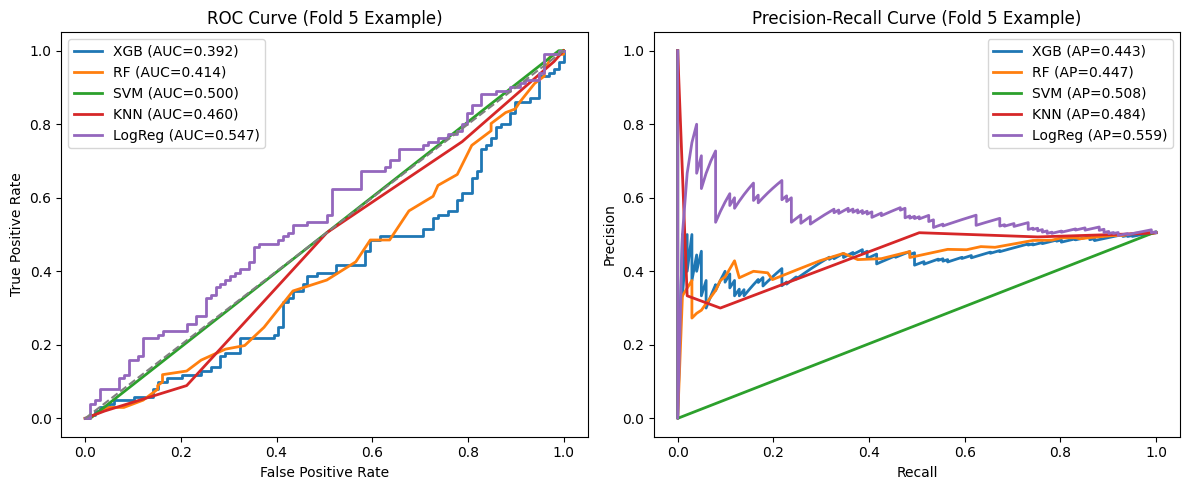

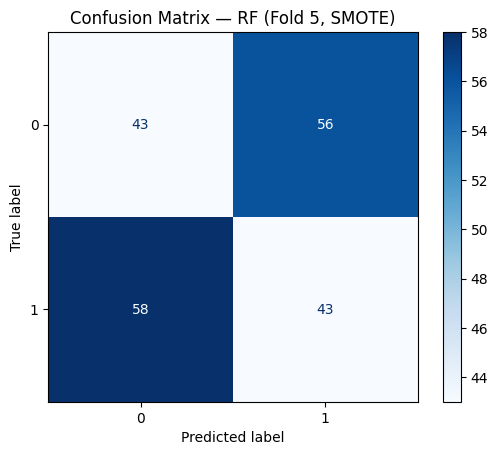

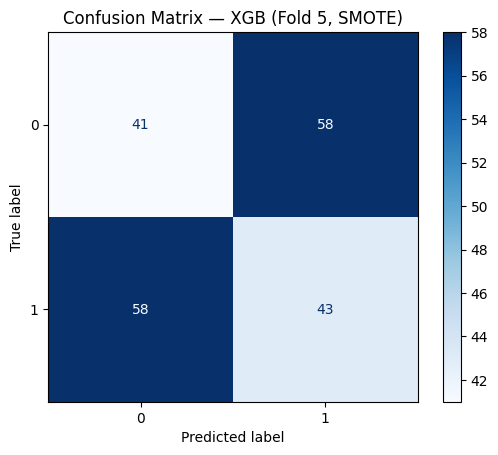

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


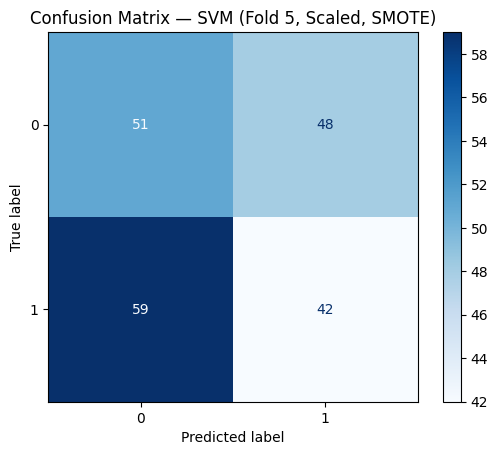

/tmp/ipython-input-634379706.py:184: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rf_imp, y="Feature", x="Importance", palette="viridis")


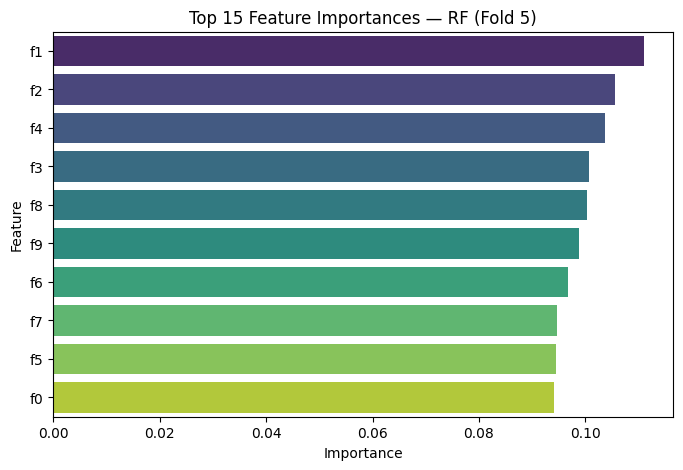

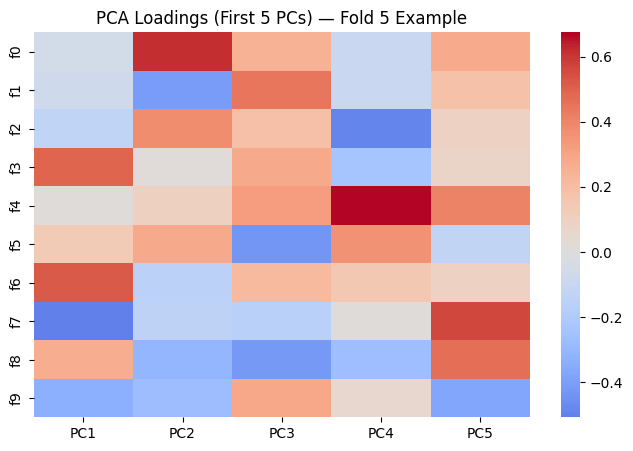

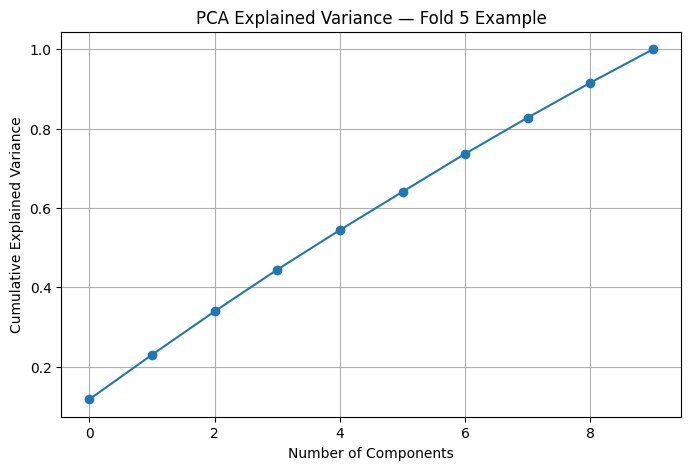

In [1]:
# -*- coding: utf-8 -*-
"""
Airline Satisfaction ML Pipeline with 5-Fold Cross Validation
and Visualisation (ROC, PR, CM, Feature Importances, PCA)
"""

# ============================ Imports ============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             roc_curve, auc, precision_recall_curve,
                             average_precision_score, accuracy_score,
                             precision_score, recall_score, f1_score)

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# ============================ Utility Functions ============================

def get_metrics(y_true, y_pred):
    """Compute evaluation metrics for binary classification."""
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Prec_0": precision_score(y_true, y_pred, pos_label=0),
        "Rec_0": recall_score(y_true, y_pred, pos_label=0),
        "F1_0": f1_score(y_true, y_pred, pos_label=0),
        "Prec_1": precision_score(y_true, y_pred, pos_label=1),
        "Rec_1": recall_score(y_true, y_pred, pos_label=1),
        "F1_1": f1_score(y_true, y_pred, pos_label=1),
        "MacroF1": f1_score(y_true, y_pred, average="macro"),
        "WeightedF1": f1_score(y_true, y_pred, average="weighted")
    }

def plot_cm(y_true, y_pred, title):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(title)
    plt.show()

def plot_roc_pr(models, X_test, y_test, title_suffix=""):
    """Plot ROC and PR curves for a set of trained models."""
    plt.figure(figsize=(12,5))

    # ROC
    plt.subplot(1,2,1)
    for name, model, X in models:
        y_score = model.predict_proba(X)[:,1] if hasattr(model,"predict_proba") else model.decision_function(X)
        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],"--",color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve {title_suffix}")
    plt.legend()

    # Precision-Recall
    plt.subplot(1,2,2)
    for name, model, X in models:
        y_score = model.predict_proba(X)[:,1] if hasattr(model,"predict_proba") else model.decision_function(X)
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        ap = average_precision_score(y_test, y_score)
        plt.plot(recall, precision, lw=2, label=f"{name} (AP={ap:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve {title_suffix}")
    plt.legend()

    plt.tight_layout()
    plt.show()

# ============================ Load & Prepare Data ============================
# Replace this with your dataset load step
# df = pd.read_csv("AirlineSatisfaction.csv")
# X = df.drop("satisfaction", axis=1)
# y = df["satisfaction"]

# Dummy example (replace with real)
X = pd.DataFrame(np.random.randn(1000, 10), columns=[f"f{i}" for i in range(10)])
y = np.random.choice([0,1], size=1000)

# ============================ Cross Validation ============================

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

fold = 0
for train_idx, test_idx in skf.split(X, y):
    fold += 1
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # SMOTE
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

    # PCA (on scaled data)
    pca = PCA(n_components=0.95, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Models
    models = {
        "XGB": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
        "RF": RandomForestClassifier(random_state=42),
        "SVM": SVC(probability=True, random_state=42),
        "KNN": KNeighborsClassifier(),
        "LogReg": LogisticRegression(max_iter=500, random_state=42)
    }

    for name, model in models.items():
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test)
        metrics = get_metrics(y_test, y_pred)
        metrics["Model"] = f"{name} (Fold {fold})"
        results.append(metrics)

    # Save last fold objects for visuals
    if fold == 5:
        rf, xgb_tab, svm_np, knn, logreg = (
            models["RF"], models["XGB"], models["SVM"], models["KNN"], models["LogReg"]
        )
        last_X_test, last_y_test = X_test, y_test
        last_X_train_res = X_train_res
        last_scaler, last_pca = scaler, pca

# ============================ Results ============================

df_results = pd.DataFrame(results)
df_results_grouped = (df_results
    .groupby(df_results["Model"].str.split(" ").str[0])
    .mean(numeric_only=True)
)

print("=== Average 5-Fold Results ===")
print(df_results_grouped)

# Save to CSV
csv_path = "Airline_Satisfaction_ML_Cross_Validation.csv"
df_results_grouped.to_csv(csv_path)
print(f"\nSaved cross-validation results to {csv_path}")

# ============================ Visualisations (Fold 5 example) ============================

# ROC & PR curves
models_to_plot = [
    ("XGB", xgb_tab, last_X_test),
    ("RF", rf, last_X_test),
    ("SVM", svm_np, last_scaler.transform(last_X_test)),
    ("KNN", knn, last_scaler.transform(last_X_test)),
    ("LogReg", logreg, last_scaler.transform(last_X_test)),
]
plot_roc_pr(models_to_plot, last_X_test, last_y_test, title_suffix="(Fold 5 Example)")

# Confusion Matrices
plot_cm(last_y_test, rf.predict(last_X_test), "Confusion Matrix — RF (Fold 5, SMOTE)")
plot_cm(last_y_test, xgb_tab.predict(last_X_test), "Confusion Matrix — XGB (Fold 5, SMOTE)")
plot_cm(last_y_test, svm_np.predict(last_scaler.transform(last_X_test)), "Confusion Matrix — SVM (Fold 5, Scaled, SMOTE)")

# Feature Importances (Random Forest as example)
rf_imp = (pd.DataFrame({"Feature": last_X_train_res.columns if hasattr(last_X_train_res,"columns") else X.columns,
                        "Importance": rf.feature_importances_})
          .sort_values("Importance", ascending=False).head(15))

plt.figure(figsize=(8,5))
sns.barplot(data=rf_imp, y="Feature", x="Importance", palette="viridis")
plt.title("Top 15 Feature Importances — RF (Fold 5)")
plt.show()

# PCA Loadings (Fold 5)
loadings = pd.DataFrame(
    last_pca.components_.T,
    index=X.columns,
    columns=[f"PC{i+1}" for i in range(last_pca.n_components_)]
)
plt.figure(figsize=(8,5))
sns.heatmap(loadings.iloc[:,:5], cmap="coolwarm", center=0)
plt.title("PCA Loadings (First 5 PCs) — Fold 5 Example")
plt.show()

# PCA Explained Variance
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(last_pca.explained_variance_ratio_), marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance — Fold 5 Example")
plt.grid(True)
plt.show()
